# Text Summarization - LSTM Word2Vec Attention

### Importing Basic libraries

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from tensorflow.python.keras.layers import Layer


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 2.0 MB/s eta 0:00:01


### Importing Data

In [3]:
data = pd.read_excel('../input/inshorts-news-data/Inshorts Cleaned Data.xlsx')

In [4]:
data.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
data.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


### Punctuation and Stopword Removal

In [5]:
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    #text = ' '.join([contractions.fix(word) for word in text.split(" ")])    
    
    tokens = [w for w in text.split() if not w in stop_words]
    text = " ".join(tokens)
    text = text.replace("'s",'')
    text = text.replace(".",'')
    text = re.sub(r'\(.*\)','',text)
    text = re.sub(r'[^a-zA-Z0-9. ]',' ',text)
    text = re.sub(r'\.','. ',text)
    text = re.sub(r'\s+', ' ', text)
    return text


### Lemmatization

In [6]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [7]:
data.rename(columns={'Headline': 'headlines', 'Short': 'text'}, inplace=True)

In [8]:
original_text = str(data['text'][0])
original_headline = str(data['headlines'][0])

In [9]:
processed_text = data['text'].apply(preprocess)
data['text'] = processed_text.apply(lemmatize_text)
data['headlines'] = data['headlines'].apply(lambda x : '_START_ '+ x + ' _END_')

for i in range(2):
    print('Summary:', data['headlines'][i],'Text:', data['text'][i], sep='\n')
    print()

Summary:
_START_ 4 ex-bank officials booked for cheating bank of ₹209 crore _END_
Text:
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis forge fabricate document fund fraudulently transfer company own accuse person

Summary:
_START_ Supreme Court to go paperless in 6 months: CJI _END_
Text:
chief justice js khehar say supreme court go paperless six seven month bid save fund make judiciary eco friendly say apex court collect record electronically low court high court need file hard copy



### Sample Input

In [10]:
print("\nORIGINAL")
print(original_text)
print(original_headline)

print("\nREGEX CLEANING AND STOPWORD REMOVAL:")
print(processed_text[0])
# print(brief_cleaned_summary[0])

print("\nLEMMATIZATION + START AND END TOKEN")
print(data['text'][0])
print(data['headlines'][0])


ORIGINAL
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.
4 ex-bank officials booked for cheating bank of ₹209 crore

REGEX CLEANING AND STOPWORD REMOVAL:
cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing 209 crore loss state run bank accused availed home loans credit syndicate bank basis forged fabricated documents funds fraudulently transferred companies owned accused persons

LEMMATIZATION + START AND END TOKEN
cbi saturday book four former official syndicate bank six other cheat forgery criminal conspiracy cause 209 crore loss state run bank accuse availed home loan credit syndicate bank basis 

In [11]:
headlines_length = [len(x.split()) for x in data.headlines]
text_length = [len(x.split()) for x in data.text]

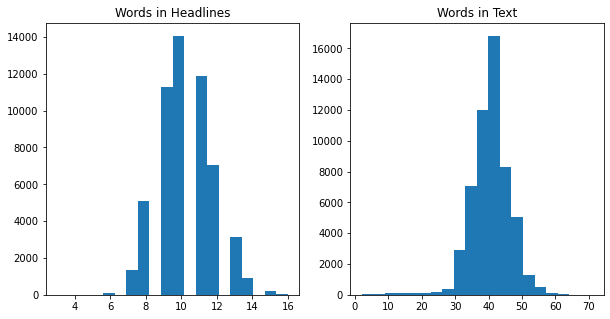

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.hist(headlines_length, bins = 20)
ax2.hist(text_length, bins = 20)

ax1.title.set_text("Words in Headlines")
ax2.title.set_text("Words in Text")
plt.show()

### Embedding Matrix from Glove


In [13]:
numWords = 62369
from gensim.models import Word2Vec
sentences = [line.split(' ') for line in data['text']]
word2vec = Word2Vec(sentences = sentences, min_count = 1)
word2vec.wv.save_word2vec_format('word2vec_vector.txt')

In [14]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('./word2vec_vector.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 64602 word vectors.


In [15]:
def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words = numWords, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = ' ', char_level = False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer, dataframe

In [16]:
def tokenizeAndEmbedding(dataframe):
    tokenizer_x, X = wordTokenizer(data['text'])
    tokenizer_y, Y = wordTokenizer(data['headlines'])

    embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer_x.index_word.items():
        if i<numWords+1:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    print(embedding_matrix.shape)
    return embedding_matrix

In [17]:
embedding_matrix = tokenizeAndEmbedding(data)

(62370, 100)


In [18]:
words_source_train = []
for i in data['text'] :
  words_source_train.extend(i.split(' '))

print("all the words in the corpus", len(words_source_train))
words_source_train = set(words_source_train)
print("the unique words in the corpus", len(words_source_train))
inter_words = set(embeddings_index.keys()).intersection(words_source_train)
print("The number of words that are present in both glove vectors and our corpus are {} which \
is nearly {}% ".format(len(inter_words), np.round((float(len(inter_words))/len(words_source_train))
*100)))

words_corpus_source_train = {}
words_glove = set(embeddings_index.keys())
for i in words_source_train:
  if i in words_glove:
    words_corpus_source_train[i] = embeddings_index[i]
print("word 2 vec length", len(words_corpus_source_train))

all the words in the corpus 2235820
the unique words in the corpus 64601
The number of words that are present in both glove vectors and our corpus are 64600 which is nearly 100.0% 
word 2 vec length 64600


In [19]:
print(list(words_source_train - inter_words)[:20])

['']


In [20]:
def num(text):
  words = [w for w in text.split() if not w in inter_words]
  return len(words)

data['unique_words'] = data['text'].apply(num)

In [21]:
data['unique_words'].value_counts()

0    55104
Name: unique_words, dtype: int64

In [22]:
data = data[data['unique_words'] < 4]
data.reset_index(inplace=True, drop=True)

In [23]:
data

,headlines,text,unique_words
0,_START_ 4 ex-bank officials booked for cheatin...,cbi saturday book four former official syndica...,0
1,_START_ Supreme Court to go paperless in 6 mon...,chief justice js khehar say supreme court go p...,0
2,"_START_ At least 3 killed, 30 injured in blast...",least three people kill include policeman 30 o...,0
3,_START_ Why has Reliance been barred from trad...,mukesh ambani lead reliance industries 2007 ri...,0
4,_START_ Was stopped from entering my own studi...,tv news anchor arnab goswami say tell could pr...,0
...,...,...,...
55099,_START_ Sensex loses 400 points to hit 52-week...,track weak cue asian market benchmark sensex w...,0
55100,_START_ China to inject $91 bn into the money ...,amid grow concern china 39 s economic growth r...,0
55101,_START_ Ghulam Ali set to make acting debut in...,pakistani ghazal singer ghulam ali soon make a...,0
55102,_START_ IS acknowledges death of Jihadi John: ...,islamic state acknowledge death 39 jihadi john...,0


### Splitting Data

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['headlines'], test_size = 0.2, random_state = 20)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size = 0.5, random_state = 20)

In [25]:
max_length_x = max(text_length)
max_length_y = max(headlines_length)

### Tokenization

In [26]:
x_t = Tokenizer()
x_t.fit_on_texts(data['text'] + data['headlines'])
x_vocab_size = len(x_t.word_index) + 1

encoded_xtrain = x_t.texts_to_sequences(X_train)
encoded_xval = x_t.texts_to_sequences(X_val)
encoded_xtest = x_t.texts_to_sequences(X_test)

padded_xtrain = pad_sequences(encoded_xtrain, maxlen=max_length_x, padding='post')
padded_xval = pad_sequences(encoded_xval, maxlen=max_length_x, padding='post')
padded_xtest = pad_sequences(encoded_xtest, maxlen=max_length_x, padding='post')

In [27]:
y_t = Tokenizer()
y_t.fit_on_texts(data['headlines'])
y_vocab_size = len(y_t.word_index) + 1

encoded_ytrain = y_t.texts_to_sequences(y_train)
encoded_yval = y_t.texts_to_sequences(y_val)
encoded_ytest = y_t.texts_to_sequences(y_test)

padded_ytrain = pad_sequences(encoded_ytrain, maxlen=max_length_y, padding='post')
padded_yval = pad_sequences(encoded_yval, maxlen=max_length_y, padding='post')
padded_ytest = pad_sequences(encoded_ytest, maxlen=max_length_y, padding='post')

In [28]:
print('Loaded %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((x_vocab_size, 100))
for word, i in x_t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 64602 word vectors.


### Building Model

In [29]:
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
          
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  
            
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            e_i = K.softmax(e_i)

            return e_i, [e_i]

        def context_step(inputs, states):
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            
            fake_state = K.zeros_like(inputs)  
            fake_state = K.sum(fake_state, axis=[1, 2])  
            fake_state = K.expand_dims(fake_state)  
            fake_state = K.tile(fake_state, [1, hidden_size])  
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  

        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )
        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


In [31]:
latent_dim=500

K.clear_session() 

encoder_inputs = Input(shape=(max_length_x,)) 
enc_emb = Embedding(x_vocab_size, 100, weights=[embedding_matrix],input_length=max_length_x, trainable=False)(encoder_inputs) 

#LSTM 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_vocab_size, 100, weights=[embedding_matrix],input_length=max_length_x, trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 71, 100)      7059100     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 71, 500), (N 1202000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [33]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
checkpoint_filepath = './model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True, save_freq = "epoch")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
history=model.fit(
    [padded_xtrain,padded_ytrain[:,:-1]], 
    padded_ytrain.reshape(padded_ytrain.shape[0],padded_ytrain.shape[1], 1)[:,1:], 
    epochs=150,
    batch_size=512, 
    validation_data=([padded_xval,padded_yval[:,:-1]], padded_yval.reshape(padded_yval.shape[0],padded_yval.shape[1], 1)[:,1:]), 
    callbacks=[model_checkpoint_callback])

Epoch 1/150
87/87 [==============================] - 31s 182ms/step - loss: 7.8637 - val_loss: 5.3985
Epoch 2/150
87/87 [==============================] - 14s 160ms/step - loss: 5.2228 - val_loss: 4.9548
Epoch 3/150
87/87 [==============================] - 14s 161ms/step - loss: 4.8390 - val_loss: 4.7915
Epoch 4/150
87/87 [==============================] - 14s 161ms/step - loss: 4.7049 - val_loss: 4.6929
Epoch 5/150
87/87 [==============================] - 14s 161ms/step - loss: 4.6212 - val_loss: 4.6620
Epoch 6/150
87/87 [==============================] - 14s 161ms/step - loss: 4.5638 - val_loss: 4.5487
Epoch 7/150
87/87 [==============================] - 14s 161ms/step - loss: 4.4734 - val_loss: 4.4797
Epoch 8/150
87/87 [==============================] - 14s 161ms/step - loss: 4.3979 - val_loss: 4.4534
Epoch 9/150
87/87 [==============================] - 14s 160ms/step - loss: 4.3281 - val_loss: 4.3725
Epoch 10/150
87/87 [==============================] - 14s 161ms/step - loss: 4.262

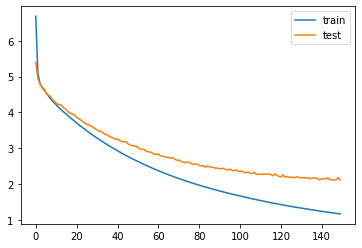

In [34]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [35]:
model.save_weights("final_weights.h5")

### Inference

In [36]:
reverse_target_word_index = y_t.index_word 
reverse_source_word_index = x_t.index_word 
target_word_index = y_t.word_index

In [45]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length_x,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat)

decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    input_seq= input_seq.reshape(1,max_length_x)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
  
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
 
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_length_y-1)):
                stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [47]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [48]:
print("Review:",seq2text(padded_xtest[13]))
print("Original summary:",seq2summary(padded_ytest[13]))
print("Predicted summary:",decode_sequence(padded_xtest[13]))


Review: rafael benitez appoint new manager relegation threaten premier league outfit newcastle united magpies sack previous manager steve mclaren early today benitez sack real madrid january seven month charge sign three year deal newcastle previously manage liverpool inter milan napoli valencia 
Original summary: rafael benitez hired as newcastle united manager 
Predicted summary:  rafael benitez hired as newcastle united manager



In [49]:
print("Review:",seq2text(padded_xtest[25]))
print("Original summary:",seq2summary(padded_ytest[25]))
print("Predicted summary:",decode_sequence(padded_xtest[25]))


Review: mall china 39 s shanxi create rooster statue resemble us president elect donald trump small replicas statue available sale price start 3 800 11 lakh 32 foot tall statue notably new year china begin january 28 year rooster accord chinese zodiac 
Original summary: china mall installs 39 donald trump like 39 rooster statue 
Predicted summary:  china mall installs 39 donald trump statue 39 china



In [50]:
print("Review:",seq2text(padded_xtest[48]))
print("Original summary:",seq2summary(padded_ytest[48]))
print("Predicted summary:",decode_sequence(padded_xtest[48]))


Review: usa become first nation register gold medal rio olympics 2016 19 year old virginia thrasher gold 10 metre air rifle day one event hold saturday thrasher finish ahead china 39 s du li yi sile silver bronze medal open china 39 s medal tally event 
Original summary: usa wins first gold medal of rio olympics 2016 
Predicted summary:  usa wins first gold medal at rio olympics



### Evaluation

In [51]:
def BLEU_Score(y_test, y_pred):
    references = [[seq2summary(y_test).split(" ")]]
    candidates = [decode_sequence(y_pred.reshape(1,max_length_x)).split(" ")]
    return corpus_bleu(references, candidates)


In [52]:
from nltk.translate.bleu_score import corpus_bleu
scores=[]
for i in range(0,500):
    scores.append(BLEU_Score(padded_ytest[i],padded_xtest[i]))
    
print(np.mean(scores))

0.7481308429501642
